# Reinforcement Learning: CartPole Policy Gradient (REINFORCE) Solution

<img src="./screenshots/policy_gradient.png" alt="drawing" width="1500"/>

In [1]:
import gym
import numpy as np
import random
import math

from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

### Plot our rewards and losses at recurrent intervals

In [2]:
def plot(frame, rewards, losses):
    clear_output(True)
    plt.figure(figsize=(20, 5))
    plt.subplot(131)
    plt.title("frame %s. reward: %s" % (frame, np.mean(rewards[-10:])))
    plt.plot(rewards)
    plt.subplot(132)
    plt.title('loss')
    plt.plot(losses)
    plt.ylim(0, 200)
    plt.show()

### Build policy gradient network using Pytorch

In [3]:
class PolicyGradient(nn.Module):
    def __init__(self):
        super(PolicyGradient, self).__init__()
        self.fc1 = nn.Linear(4, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 2)
        
    def forward(self, states):
        out = F.relu(self.fc1(states))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out

#### Initialize policy gradient network

In [4]:
policy_gradient = PolicyGradient()

#### Initialize Adam optimizer for our model

In [5]:
optimizer = optim.Adam(policy_gradient.parameters())

### Training Loop

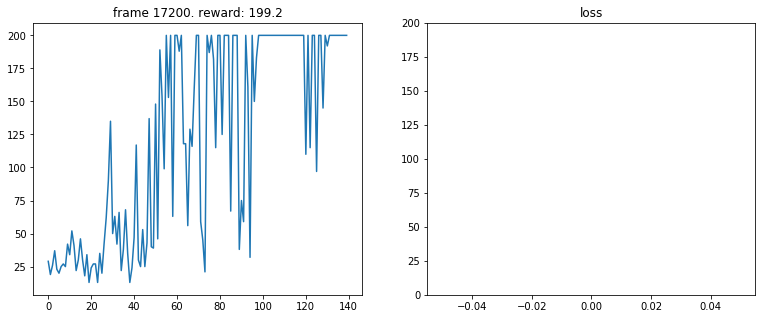

In [ ]:
gamma = 1.0
frame = 0
all_rewards = []
all_losses = []
env = gym.make('CartPole-v0')

for episode in range(400):
    observation = env.reset()
    env.render()
    lifespan = []
    counter = 0
    
    trajectory = []
    
    while True:
        frame += 1
        counter += 1
        env.render()
        
        optimizer.zero_grad()
        
        # get probability distributions of actions from our policy gradient network
        observation_tensor = torch.tensor([observation], dtype=torch.float)
        output = policy_gradient(observation_tensor)
        softmax = nn.Softmax()
        output = softmax(output)
        output = output.view(output.size(1))
        output = output.detach().numpy()
        # weighted sample to get action
        action = np.random.choice(a=[0, 1], size=1, p=output).item()
        
        # take action in real world
        next_observation, reward, done, info = env.step(action)
        # store experience in trajectory
        trajectory.append([observation, action, reward, next_observation, done])
        
        observation = next_observation.copy()
        
        if done:
            break
            
        if frame % 200 == 0:
            plot(frame, all_rewards, all_losses)
            
    #episode ends; learn from trajectories
    
    for timestep_idx in range(0, len(trajectory)):
        optimizer.zero_grad()
        
        observation_tensor = torch.tensor([trajectory[timestep_idx][0]], dtype=torch.float)
        output = policy_gradient(observation_tensor)
        softmax = nn.Softmax()
        output = softmax(output)
        output = output.view(output.size(1))
        output = output[trajectory[timestep_idx][1]]
        output = torch.log(output)
        
        cum_reward = 0
        for i in range(timestep_idx, len(trajectory)):
            cum_reward += trajectory[i][2]
            
        output = -1 * output * cum_reward
        
        output.backward()
        optimizer.step()
    
    
    
    lifespan.append(counter)
    all_rewards.append(counter)